# SVM and SHAP values for Validation cohort of ER+ tumors

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt
#from statsmodels.stats.weightstats import ttest_ind
%matplotlib inline

#from google.colab import drive
#drive.mount('/content/drive')
data2 = pd.read_csv("~/AllSamplesCellFractionsAveraged10SM.csv")
data2.head()

,Trial,Mixture,B.cells.Memory,B.cells.Naive,CAFs.MSC.iCAF.like,CAFs.myCAF.like,DCs,Endothelial.ACKR1,Endothelial.CXCL12,Endothelial.LYVE1,...,Myeloids,BCells,CAFs,PVLs,Endothelials,ER,PAM50,Response,RoRScore,RoRRisk
0,GSE22093,GSM549230,0.017895,0.005095,0.029985,0.086698,0.015332,0.004916,0.117291,0.007518,...,0.091443,0.022990,0.116683,0.039040,0.164980,Negative,Basal,pCR,0.596054,High
1,GSE22093,GSM549231,0.001398,0.030779,0.011099,0.115468,0.007091,0.003519,0.029935,0.002120,...,0.124711,0.032177,0.126567,0.024725,0.064267,Negative,Her2,pCR,0.599059,High
2,GSE22093,GSM549232,0.001909,0.012753,0.000000,0.051034,0.003823,0.000000,0.002719,0.000241,...,0.061014,0.014662,0.051034,0.016053,0.054086,Positive,Basal,pCR,0.775378,High
3,GSE22093,GSM549233,0.000000,0.008309,0.002679,0.086790,0.000110,0.000000,0.022606,0.001387,...,0.134695,0.008309,0.089469,0.010784,0.059115,Negative,Basal,RD,0.786744,High
4,GSE22093,GSM549234,0.000000,0.009694,0.000000,0.060985,0.038723,0.000000,0.001546,0.000000,...,0.111366,0.009694,0.060985,0.004148,0.068835,Negative,Basal,RD,0.940486,High


In [2]:
data= data2
resp = {'pCR': 1,'RD': 0}
data.Response = [resp[item] for item in data.Response]
data= data.loc[data['ER'] == 'Positive']

categorical_cols = ['PAM50']  
data = pd.get_dummies(data, columns = categorical_cols) 
# data= data[data['Trial'].isin(['E-MTAB-4439','GSE18728','GSE19697', 'GSE20194', 'GSE20271', 'GSE22093', 'GSE22358', 'GSE42822','GSE22513'])]
data= data[data['Trial'].isin(['GSE25066','GSE32603','GSE32646','GSE37946','GSE50948', 'GSE23988'])] 
data.to_csv('.../ER+/ValidationData.csv') 
data.shape

(528, 47)

# Preprocessing 

In [3]:
# Import the necessary libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn import preprocessing

 
# Extract the features (independent variables) and create a DataFrame 'X'
# Drop the columns 'Trial', 'Mixture', 'Response', and 'Cohort' from the data to get the features
X = pd.DataFrame(data.drop(['Trial', 'Mixture', 'Response', 'Cohort'], axis=1))

# Create a copy of 'X' in DataFrame 'd3' (later to be used in SHAP analysis)
d3 = pd.DataFrame(data.drop(['Trial', 'Mixture', 'Response', 'Cohort'], axis=1))

# Extract the target variable 'y' (dependent variable) from the 'data' DataFrame
y = data['Response']

# Perform standardization on the features using the StandardScaler from sklearn
# This step scales the features to have mean 0 and standard deviation 1
# This is important for some machine learning algorithms that are sensitive to feature scales
X = pd.DataFrame(preprocessing.StandardScaler().fit(X).transform(X), columns=d3.columns)

 
X.head()

,B.cells.Memory,B.cells.Naive,CAFs.MSC.iCAF.like,CAFs.myCAF.like,DCs,Endothelial.ACKR1,Endothelial.CXCL12,Endothelial.LYVE1,Endothelial.RGS5,GenMod1,...,Myeloids,BCells,CAFs,PVLs,Endothelials,PAM50_Basal,PAM50_Her2,PAM50_LumA,PAM50_LumB,PAM50_Normal
0,-0.182414,-0.522889,-0.415809,0.232874,1.247518,-0.277132,-0.586003,-0.614601,0.826725,1.466322,...,-0.161743,-0.541982,0.122163,-0.444981,0.055903,3.696846,-0.274511,-1.011429,-0.606528,-0.308927
1,0.883433,-0.542897,-0.220821,-0.361663,2.196725,-0.277132,-0.567503,-0.454167,0.364527,0.903906,...,0.266676,0.200671,-0.418886,0.408172,-0.199840,-0.270501,-0.274511,-1.011429,1.648730,-0.308927
2,1.057540,-0.353679,1.720116,-0.267267,0.403990,-0.222832,3.820601,1.043374,2.136282,-0.702349,...,-0.751953,0.473717,0.188471,0.443600,3.420889,-0.270501,-0.274511,0.988700,-0.606528,-0.308927
3,1.114117,-0.653539,1.688950,-0.061267,0.111096,0.022604,0.985044,0.214215,0.637140,-0.027434,...,-0.657605,0.277602,0.385562,-0.064661,0.939923,-0.270501,-0.274511,0.988700,-0.606528,-0.308927
4,1.587734,-0.712648,-0.415809,0.128089,0.763221,-0.277132,-0.586003,-0.222332,1.487841,1.207608,...,-0.330708,0.568020,0.017716,-0.568948,0.620924,-0.270501,3.642838,-1.011429,-0.606528,-0.308927


#  Test Train

In [4]:
#   Import necessary ML packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Split into training/testing datasets using Train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3333,random_state=10)#


#X_train, y_train = X,y 
#X_test, y_test = X,y 

#X_train,X_test,y_train,y_test= np.asarray(X_train), np.asarray(X_test), np.asarray(y_train), np.asarray(y_test)

print ('Train set:', X_train.shape,y_train.shape)
print ('Test set: ', X_test.shape, y_test.shape)

Train set: (352, 41) (352,)
Test set:  (176, 41) (176,)


# Support Vector Machine

In [5]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import svm

clf = svm.SVC(C=4,gamma=0.04,kernel='rbf',probability=True, class_weight='balanced')  # 

cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model = clf #svm.SVC(C=1,kernel='linear',probability=True)
# evaluate model
Acc_score = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
f1_score = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(Acc_score)*100, std(Acc_score)*100))
print('f1 score: %.3f (%.3f)' % (mean(f1_score), std(f1_score)))

Accuracy: 83.130 (3.920)
f1 score: 0.351 (0.081)


 # SHAP Analysis

In [7]:
!pip install shap
import shap


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\Youness\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
clf.fit(X,y)

svm_explainer=shap.KernelExplainer(clf.predict, X )
svm_shap_values=svm_explainer.shap_values(X)

X does not have valid feature names, but SVC was fitted with feature names
Using 528 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/528 [00:00<?, ?it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set p

In [9]:
svm_shap= pd.DataFrame(svm_shap_values,columns=d3.columns)
svm_shap.to_csv('.../ER+/ValidationSHAP.csv') 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


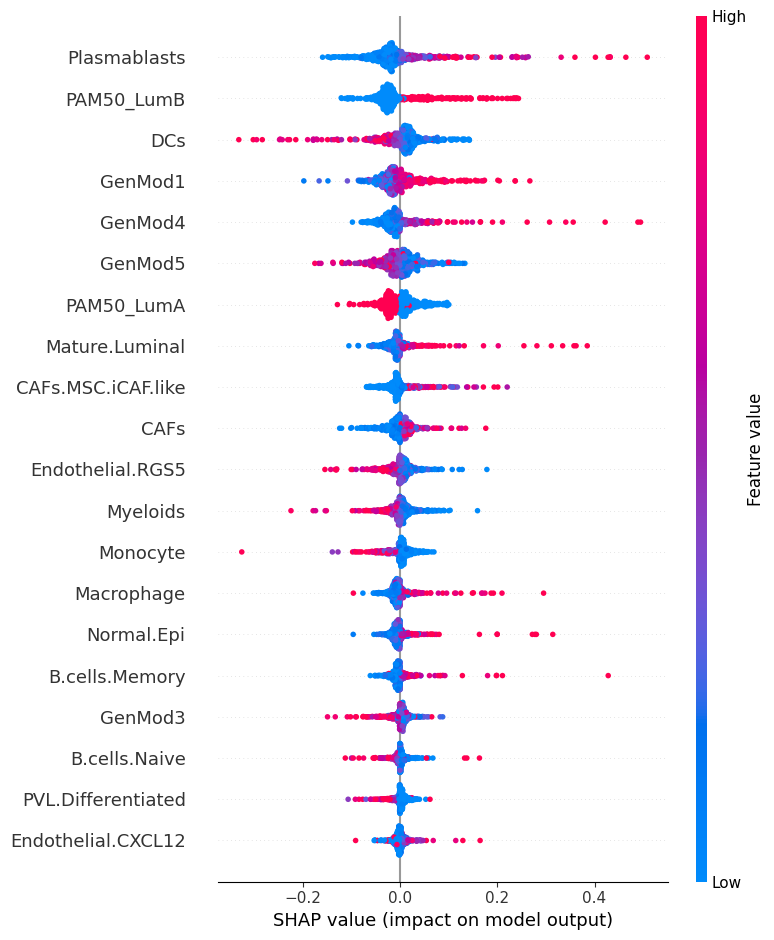

In [10]:
shap.summary_plot(svm_shap_values, X,feature_names=d3.columns)

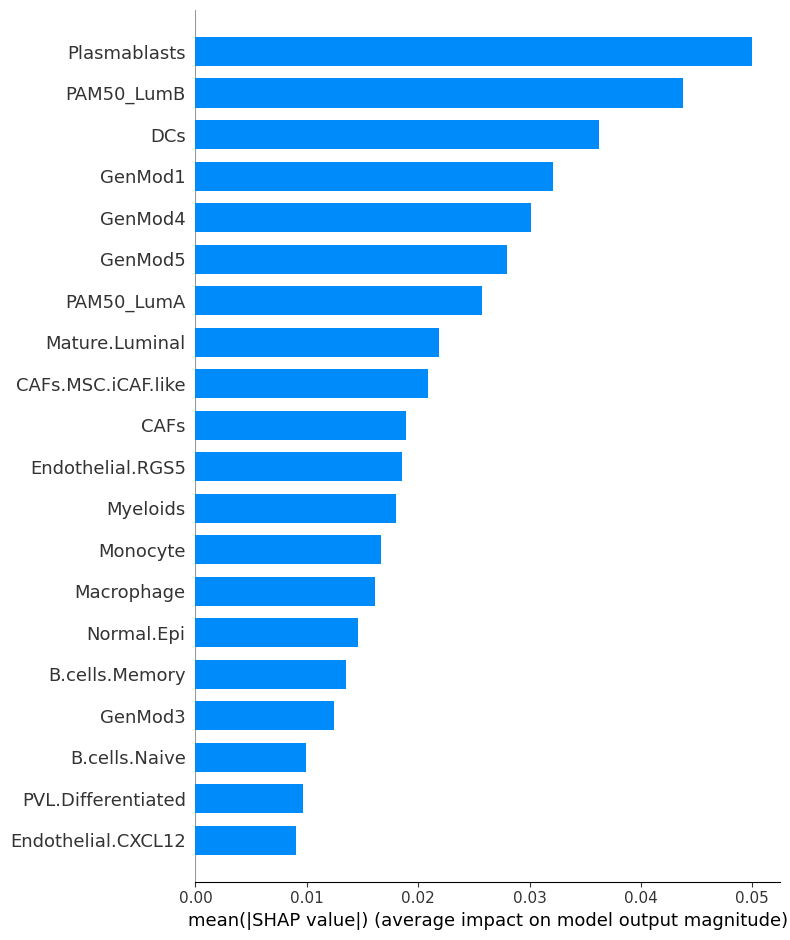

In [11]:
shap.summary_plot(svm_shap_values, X, feature_names=d3.columns, plot_type="bar")

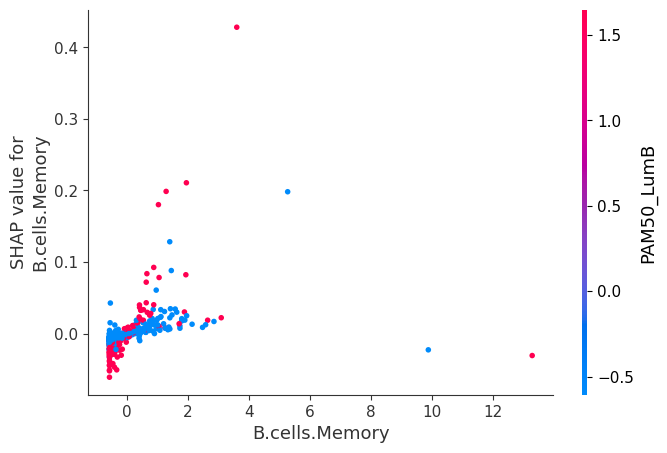

In [12]:
shap.dependence_plot(0, svm_shap_values,X_test, feature_names=d3.columns)